In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error
from typing import Union
import warnings
from features import *
from evaluate import *
from ImageQualityAssessmentPAD import *
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pickle

In [2]:
os.getcwd()

'/home/anhnq47/Documents/Anti_Spoofing'

In [3]:
file_path = '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace'
real_faces = glob.glob(f'{file_path}/Client*/*/*.jpg')
fake_faces = glob.glob(f'{file_path}/Imposter*/*/*.jpg')
real_faces

['/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/0001/0001_00_00_01_0.jpg',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/0001/0001_00_00_01_101.jpg',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/0001/0001_00_00_01_105.jpg',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/0001/0001_00_00_01_109.jpg',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/0001/0001_00_00_01_112.jpg',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/0001/0001_00_00_01_116.jpg',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/0001/0001_00_00_01_12.jpg',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/0001/0001_00_00_01_123.jpg',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/0001/0001_00_00_01_127.jpg',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/ClientFace/00

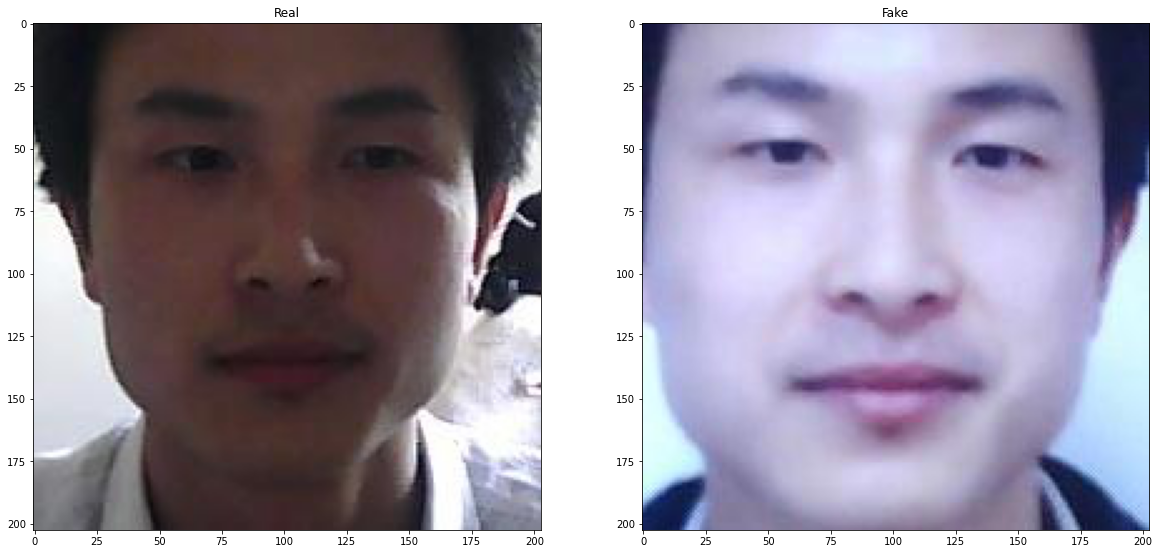

In [4]:
index = 3
real_img = plt.imread(real_faces[index])
fake_img = plt.imread(fake_faces[index])
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow(real_img)
ax1.set_title('Real')
ax2.imshow(fake_img)
ax2.set_title('Fake')
plt.show()


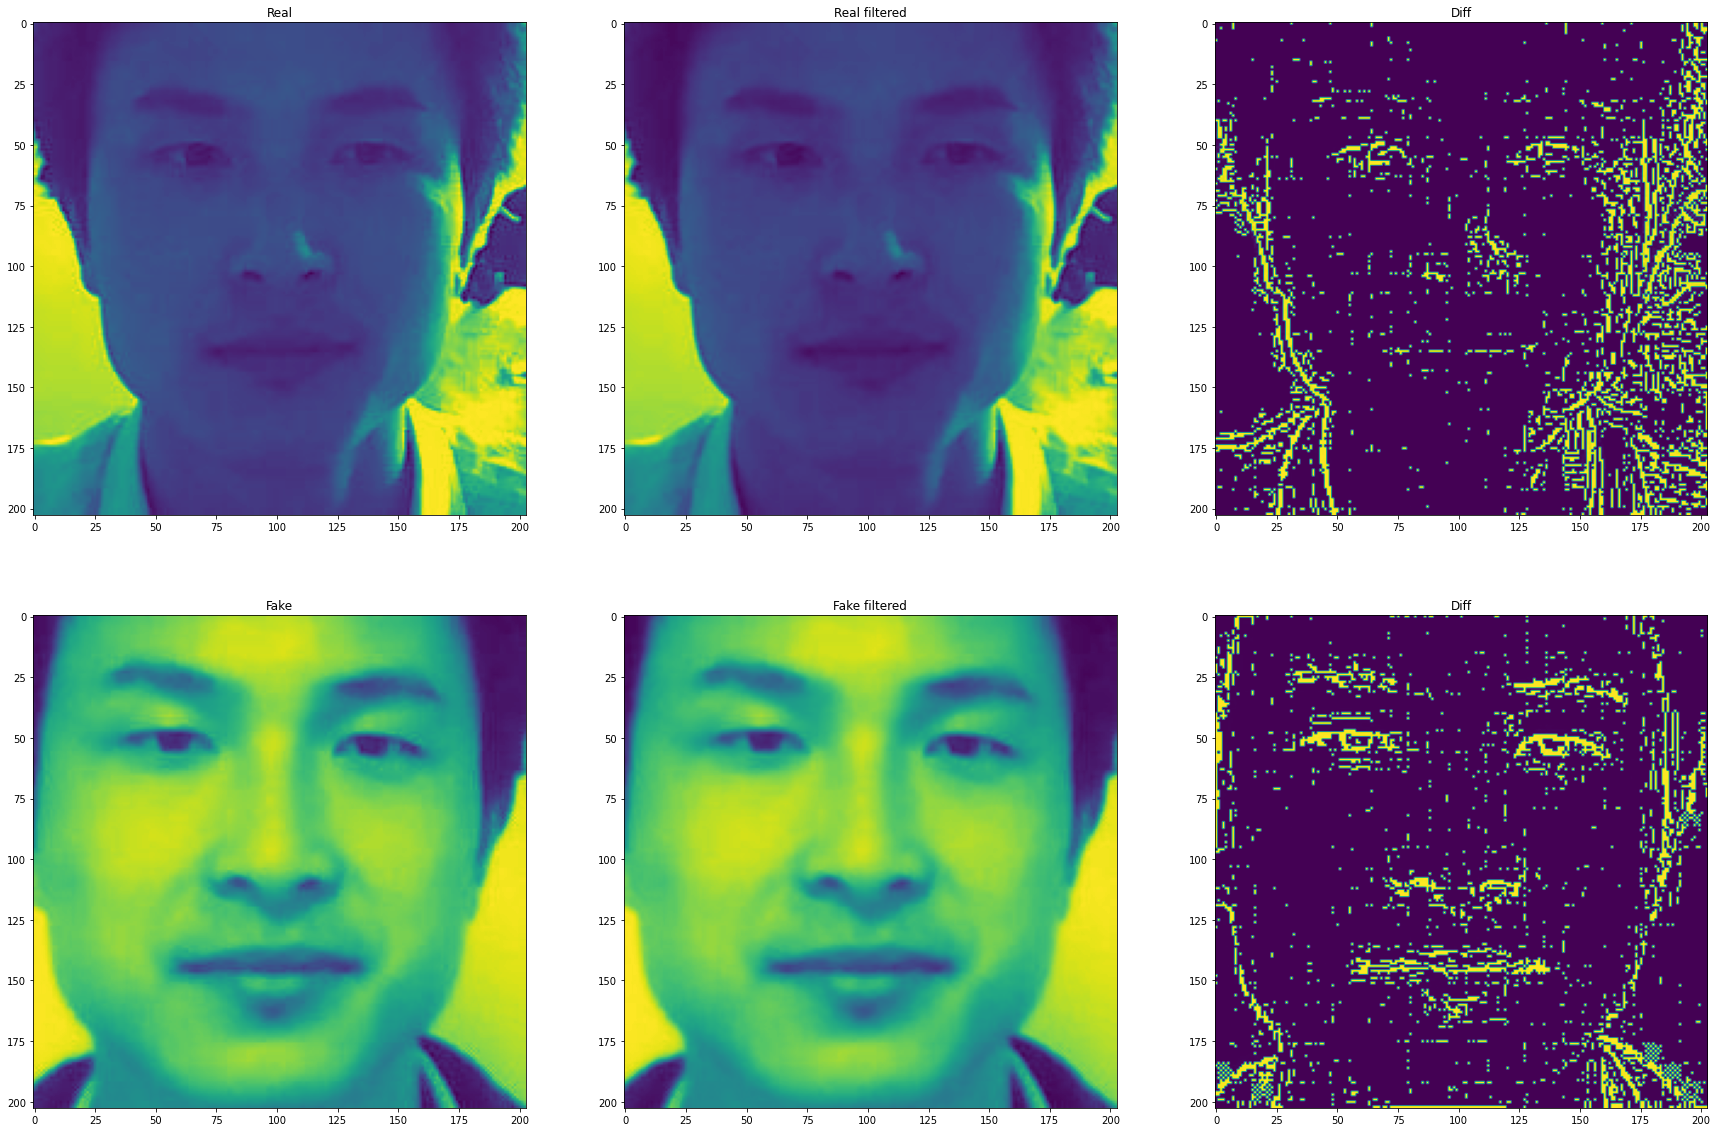

In [5]:
fig, axs = plt.subplots(2,3, figsize = (30,20))
real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY)
axs[0,0].imshow(real_img)
axs[0,0].set_title('Real')

real_blur = cv2.GaussianBlur(real_img, (3,3), sigmaX = 0.5, sigmaY = 0.5)
axs[0,1].imshow(real_blur)
axs[0,1].set_title('Real filtered')

real_unsharp_mask = real_img - real_blur 
axs[0,2].imshow(real_unsharp_mask)
axs[0,2].set_title('Diff')

fake_img = cv2.cvtColor(fake_img, cv2.COLOR_BGR2GRAY)
axs[1,0].imshow(fake_img)
axs[1,0].set_title('Fake')

fake_blur = cv2.GaussianBlur(fake_img, (3,3), sigmaX = 0.5, sigmaY = 0.5)
axs[1,1].imshow(fake_blur)
axs[1,1].set_title('Fake filtered')

fake_unsharp_mask = fake_img - fake_blur 
axs[1,2].imshow(fake_unsharp_mask)
axs[1,2].set_title('Diff')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


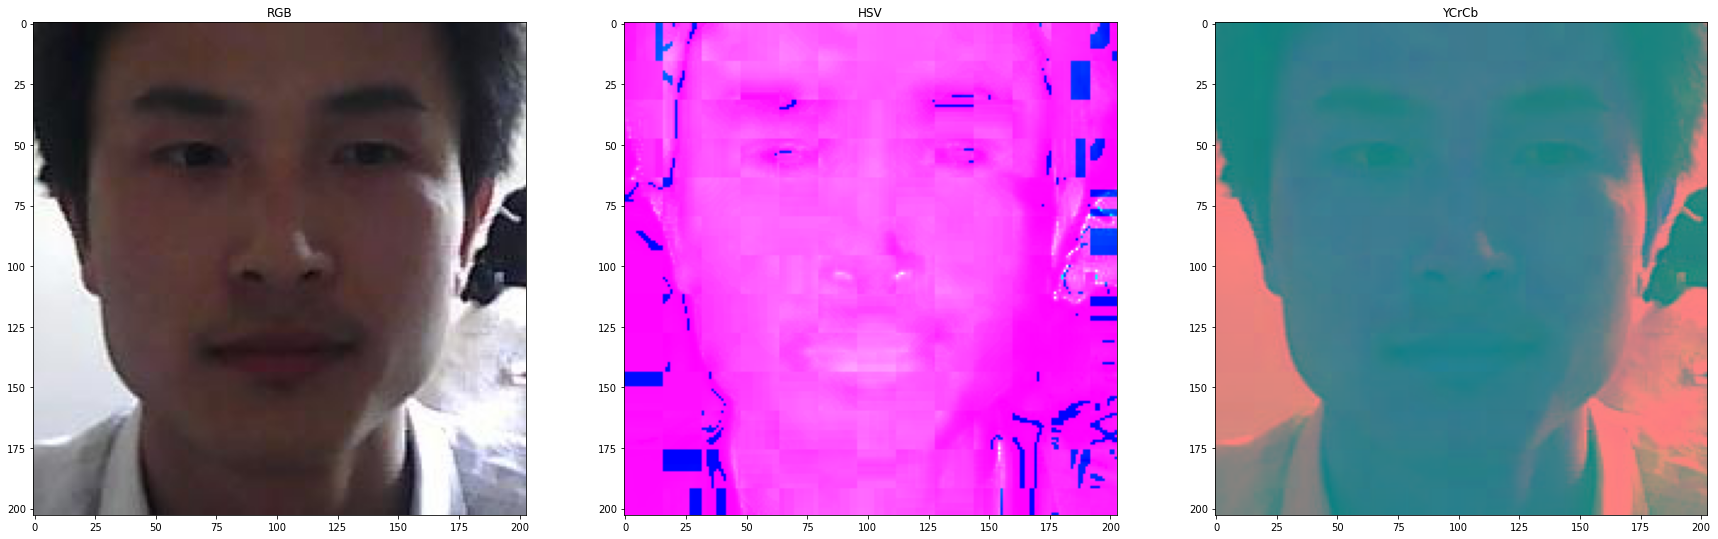

In [6]:
real_img = plt.imread(real_faces[index])
fig, axs = plt.subplots(1,3, figsize = (30,20))
axs[0].imshow(real_img)
axs[0].set_title('RGB')

HSV = cv2.cvtColor(np.float32(real_img), cv2.COLOR_BGR2HSV)
axs[1].imshow(HSV)
axs[1].set_title('HSV')

YCrCb = cv2.cvtColor(real_img, cv2.COLOR_BGR2YCrCb)
axs[2].imshow(YCrCb)
axs[2].set_title('YCrCb')
plt.show()


In [7]:
#Train test split
docs = glob.glob('/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/*txt')
docs

['/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/client_test_face.txt',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/client_train_face.txt',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/imposter_test_face.txt',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/imposter_train_face.txt',
 '/media/anhnq47/Arkham/AntiSpoofing Dataset/NUAA/DetectedFace/readme.txt']

In [8]:
client_test = [x.split('\\')[-1] for x in pd.read_csv(docs[0], sep = ' ', header = None)[0].tolist()]
X_client_test = [x for x in glob.glob(f'{file_path}/Client*/*/*.jpg') if x.split('/')[-1] in client_test]
assert(len(X_client_test) == len(client_test))
client_train = [x.split('\\')[-1] for x in pd.read_csv(docs[1], sep = ' ', header = None)[0].tolist()]
X_client_train = [x for x in glob.glob(f'{file_path}/Client*/*/*.jpg') if x.split('/')[-1] in client_train]
assert(len(client_train) == len(client_train))

imposter_test = [x.split('\\')[-1] for x in pd.read_csv(docs[2], sep = ' ', header = None)[0].tolist()]
X_imposter_test = [x for x in glob.glob(f'{file_path}/Imposter*/*/*.jpg') if x.split('/')[-1] in imposter_test]
assert(len(X_imposter_test) == len(imposter_test))
imposter_train = [x.split('\\')[-1] for x in pd.read_csv(docs[3], sep = ' ', header = None)[0].tolist()]
X_imposter_train = [x for x in glob.glob(f'{file_path}/Imposter*/*/*.jpg') if x.split('/')[-1] in imposter_train]
assert(len(imposter_train) == len(X_imposter_train))


In [9]:
train = {}
test = {}
train['X'] = X_imposter_train + X_client_train
test['X'] = X_imposter_test + X_client_test
print(len(train['X'] ))
print(len(test['X']))

3491
9123


In [10]:
train['y'] = []
test['y'] = []
for dictionary in [train, test]:
    for path in dictionary['X']:
        if(path.split('/')[-3] == 'ImposterFace'):
            dictionary['y'].append(1)
        elif(path.split('/')[-3] == 'ClientFace'):
            dictionary['y'].append(0)
        else:
            raise('WTF')
print(np.unique(train['y'], return_counts = True))
print(np.unique(test['y'], return_counts = True))

(array([0, 1]), array([1743, 1748]))
(array([0, 1]), array([3362, 5761]))


In [11]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)


In [38]:
# #CREATE MODEL WITH ALL DATA
# hsv_train = np.vstack((load('data/Xtrain_HSV.npy'), load('data/Xtest_HSV.npy')))
# print(hsv_train.shape)
# hsv_test = np.hstack((load('data/ytrain_HSV.npy'), load('data/ytest_HSV.npy')))
# print(hsv_test.shape)

# clf = ImageQualityAssessmentPAD()
# hsv_test = load('data/Xtrain_HSV.npy')
# hsv_test_y = load('data/ytrain_HSV.npy')
# model = clf.fit(hsv_test,hsv_test_y , 'SVM')

(12614, 177)
(12614,)


In [39]:
# #CREATE MODEL WITH ALL DATA
# YCrCb_train = np.vstack((load('data/Xtrain_YCrCb.npy'), load('data/Xtest_YCrCb.npy')))
# print(YCrCb_train.shape)
# YCrCb_test = np.hstack((load('data/ytrain_YCrCb.npy'), load('data/ytest_YCrCb.npy')))
# print(YCrCb_test.shape)

# clf = ImageQualityAssessmentPAD()
# # hsv_test = load('data/Xtrain_YCrCb.npy')
# # hsv_test_y = load('data/ytrain_YCrCb.npy')
# model = clf.fit(YCrCb_train,YCrCb_test , 'LDA')

/home/anhnq47/Documents/Anti_Spoofing/features.py:353: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist,_= np.histogram(lbp,  normed=True, bins=max_bins, range=(0, max_bins))


LDA
Classification Report
              precision    recall  f1-score   support

        Real       1.00      0.70      0.82      4779
    Imposter       0.75      1.00      0.86      4344

    accuracy                           0.84      9123
   macro avg       0.88      0.85      0.84      9123
weighted avg       0.88      0.84      0.84      9123

Confusion Matrix


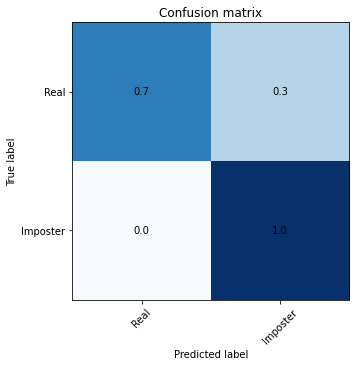

SVM
Classification Report
              precision    recall  f1-score   support

        Real       0.62      0.67      0.64      3094
    Imposter       0.82      0.79      0.80      6029

    accuracy                           0.75      9123
   macro avg       0.72      0.73      0.72      9123
weighted avg       0.75      0.75      0.75      9123

Confusion Matrix


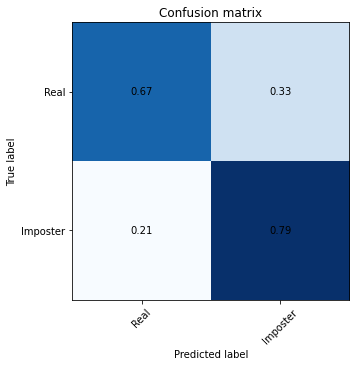

LR
Classification Report
              precision    recall  f1-score   support

        Real       1.00      0.62      0.77      5409
    Imposter       0.64      1.00      0.78      3714

    accuracy                           0.78      9123
   macro avg       0.82      0.81      0.78      9123
weighted avg       0.86      0.78      0.77      9123

Confusion Matrix


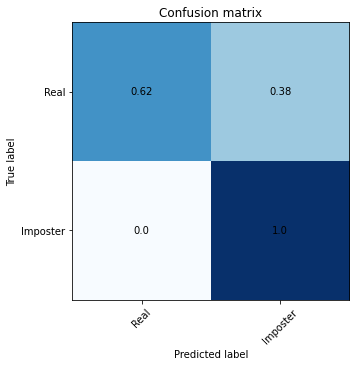

In [47]:
#YCrCb
clf = ImageQualityAssessmentPAD()
X_train_in_nparray = clf.DataGenerator(train['X'], 'BoulkenafetYCrCb')
# X_train_in_nparray = load('data/Xtrain_YCrCb.npy')
X_test_in_nparray = clf.DataGenerator(test['X'], 'BoulkenafetYCrCb')
# X_test_in_nparray = load('data/Xtest_YCrCb.npy')

print('LDA')
clf.fit(X_train_in_nparray, train['y'])
y_pred = clf.predict(X_test_in_nparray)
labels = ['Real', 'Imposter']
evaluate(y_pred, test['y'], labels)

print('SVM')
clf.fit(X_train_in_nparray, train['y'], 'SVM')
y_pred = clf.predict(X_test_in_nparray)
labels = ['Real', 'Imposter']
evaluate(y_pred, test['y'], labels)

print('LR')
clf.fit(X_train_in_nparray, train['y'], 'LR')
y_pred = clf.predict(X_test_in_nparray)
labels = ['Real', 'Imposter']
evaluate(y_pred, test['y'], labels)


In [48]:
#Saving training and testing numpy files
dump(X_test_in_nparray,'data/Xtest_YCrCb.npy')
dump(np.array(test['y']),'data/ytest_YCrCb.npy')
dump(X_train_in_nparray,'data/Xtrain_YCrCb.npy')
dump(np.array(train['y']),'data/ytrain_YCrCb.npy')

['data/ytrain_YCrCb.npy']

LDA
Classification Report
              precision    recall  f1-score   support

        Real       1.00      0.53      0.70      6302
    Imposter       0.49      1.00      0.66      2821

    accuracy                           0.68      9123
   macro avg       0.74      0.77      0.68      9123
weighted avg       0.84      0.68      0.68      9123

Confusion Matrix


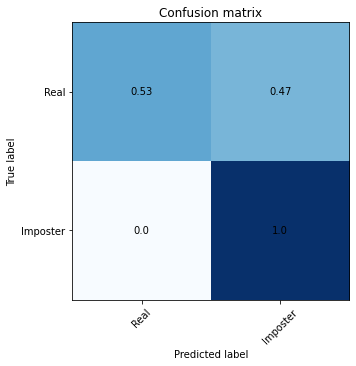

SVM
Classification Report
              precision    recall  f1-score   support

        Real       1.00      0.70      0.82      4827
    Imposter       0.75      1.00      0.85      4296

    accuracy                           0.84      9123
   macro avg       0.87      0.85      0.84      9123
weighted avg       0.88      0.84      0.84      9123

Confusion Matrix


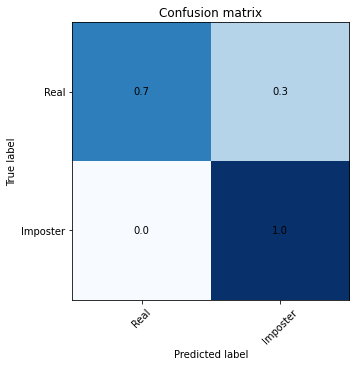

LR
Classification Report
              precision    recall  f1-score   support

        Real       1.00      0.45      0.62      7502
    Imposter       0.28      1.00      0.44      1621

    accuracy                           0.55      9123
   macro avg       0.64      0.72      0.53      9123
weighted avg       0.87      0.55      0.59      9123

Confusion Matrix


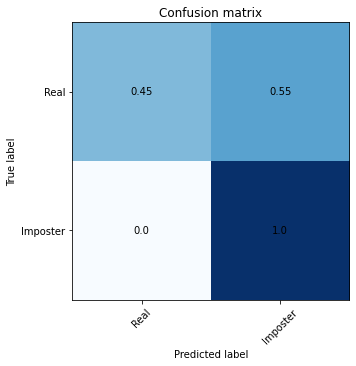

In [46]:
#HSV
clf = ImageQualityAssessmentPAD()
# X_train_in_nparray = clf.DataGenerator(train['X'], 'BoulkenafetHSV')
X_train_in_nparray = load('data/Xtrain_HSV.npy')
# X_test_in_nparray = clf.DataGenerator(test['X'], 'BoulkenafetHSV')
X_test_in_nparray = load('data/Xtest_HSV.npy')
labels = ['Real', 'Imposter']


print('LDA')
clf.fit(X_train_in_nparray, train['y'])
y_pred = clf.predict(X_test_in_nparray)
labels = ['Real', 'Imposter']
evaluate(y_pred, test['y'], labels)

print('SVM')
clf.fit(X_train_in_nparray, train['y'], 'SVM')
y_pred = clf.predict(X_test_in_nparray)
labels = ['Real', 'Imposter']
evaluate(y_pred, test['y'], labels)

print('LR')
clf.fit(X_train_in_nparray, train['y'], 'LR')
y_pred = clf.predict(X_test_in_nparray)
labels = ['Real', 'Imposter']
evaluate(y_pred, test['y'], labels)

In [41]:
#Saving training and testing numpy files
dump(X_test_in_nparray,'data/Xtest_HSV.npy')
dump(np.array(test['y']),'data/ytest_HSV.npy')
dump(X_train_in_nparray,'data/Xtrain_HSV.npy')
dump(np.array(train['y']),'data/ytrain_HSV.npy')

['data/ytrain_HSV.npy']

Classification Report
              precision    recall  f1-score   support

        Real       0.88      0.89      0.89      1526
    Imposter       0.93      0.92      0.92      2259

    accuracy                           0.91      3785
   macro avg       0.90      0.91      0.90      3785
weighted avg       0.91      0.91      0.91      3785

Confusion Matrix


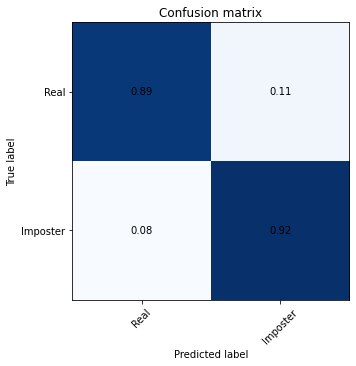

In [12]:
#Galbally RGB
clf = ImageQualityAssessmentPAD()
# X_train_in_nparray = clf.DataGenerator(X_train, 'BoulkenafetHSV')
X_train_in_nparray = load('data/Xtest_42_.npy')
clf.fit(X_train_in_nparray, y_train)
# X_test_in_nparray = clf.DataGenerator(X_test, 'BoulkenafetHSV')
X_test_in_nparray = load('data/Xactualtest_42_.npy')
y_pred = clf.predict(X_test_in_nparray)
labels = ['Real', 'Imposter']
evaluate(y_pred, test['y'], labels)


In [20]:
#Saving training and testing numpy files
# dump(X_test_in_nparray,'features/Xtest_42_HSV.npy')
# dump(np.array(y_test),'features/ytest_42_HSV.npy')
# dump(X_train_in_nparray,'features/Xtrain_42_HSV.npy')
# dump(np.array(y_train),'features/ytrain_42_HSV.npy')

['features/ytrain_42_HSV.npy']